In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# read and cleanup data
invoices_df = pd.read_csv('data/invoices.csv', parse_dates=['date'])
invoices_df['invoice_date'] = invoices_df['date'].dt.floor('d')
invoices_df.rename({'date':'invoice_time'}, axis='columns', inplace=True)
print(invoices_df.shape)
invoices_df.sample(5)

(5169, 7)


,id,invoice_time,type,workspace_id,total_cost_in_cents,total_paid_in_credits_in_cents,invoice_date
5062,inv6420120909778,2018-12-28,renewal,wks2381155806720,2400,0,2018-12-28
2185,inv3577097102676,2018-06-10,renewal,wks6196164807931,45171,0,2018-06-10
2725,inv5133574843202,2018-07-27,final,wks7017454166066,44228,0,2018-07-27
2877,inv8153499840535,2018-08-08,renewal,wks1234668746776,2400,0,2018-08-08
3424,inv3574460030472,2018-09-16,renewal,wks1097772353765,8571,0,2018-09-16


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018933AC4C08>,
      dtype=object)

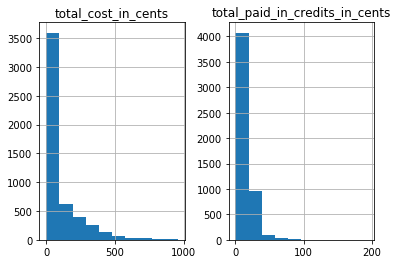

In [2]:
# data quality: check there are no negative costsor credits
(invoices_df[['total_cost_in_cents','total_paid_in_credits_in_cents']]/100).hist()

In [3]:
users_df = pd.read_csv('data/users.csv', parse_dates=['created_time'])
users_df['user_created_date'] = users_df['created_time'].dt.floor('d')
print(users_df.shape)
users_df.head()

(99770, 4)


,id,created_time,referred_by_user_id,user_created_date
0,usr1016620834375,2017-04-14 05:18:47,NaN,2017-04-14
1,usr6312056272732,2018-06-04 11:18:38,usr6152824657638,2018-06-04
2,usr9799337257680,2018-06-04 22:12:23,usr7657082619134,2018-06-04
3,usr6515617449395,2017-04-14 06:10:02,NaN,2017-04-14
4,usr5782041114846,2018-06-04 16:02:24,usr1154128672858,2018-06-04


In [4]:
workspace_df = pd.read_csv('data/workspaces.csv', parse_dates=['created_time'])
workspace_df['workspace_created_date'] = workspace_df['created_time'].dt.floor('d')
print(workspace_df.shape)
workspace_df.head()


(31321, 4)


,id,owner_id,created_time,workspace_created_date
0,wks1586547946165,usr1016620834375,2017-04-14 05:18:47,2017-04-14
1,wks621888697097,usr6515617449395,2017-04-14 06:10:02,2017-04-14
2,wks8254908357385,usr7149077031238,2017-04-14 03:09:12,2017-04-14
3,wks8280016569062,usr586041866636,2017-04-14 16:45:59,2017-04-14
4,wks3750073023271,usr7052254356072,2017-04-14 13:55:10,2017-04-14


In [5]:
collab_df = pd.read_csv('data/workspace_collaborators.csv', parse_dates=['created_time','deleted_time'])
collab_df['collab_created_date'] = collab_df['created_time'].dt.floor('d')
collab_df['collab_deleted_date'] = collab_df['deleted_time'].dt.floor('d')
print(collab_df.shape)
collab_df.head()

(69232, 7)


,id,user_id,workspace_id,created_time,deleted_time,collab_created_date,collab_deleted_date
0,col4026991301698,usr9100864407465,wks1900402835637,2017-01-05 13:41:28,NaT,2017-01-05,NaT
1,col2779233428492,usr6726149611952,wks5820915998921,2017-01-07 23:37:59,2017-03-11 10:50:33,2017-01-07,2017-03-11
2,col8719089295882,usr8900435456927,wks9234093346292,2017-01-07 11:04:25,2017-01-17 08:23:07,2017-01-07,2017-01-17
3,col3481938312136,usr7257607797305,wks7589052327742,2017-01-09 19:56:10,2017-01-09 13:08:37,2017-01-09,2017-01-09
4,col7374880844494,usr2832150637685,wks3646979824150,2017-01-09 11:24:59,2017-01-17 03:44:46,2017-01-09,2017-01-17



### Question 1:

Using this dataset, please calculate and plot recurring revenue over time.

Some workspaces may churn once they run out of credits. To account for this, exclude workspaces that have paid less than $10 (excluding credits) by the time the invoice is generated.

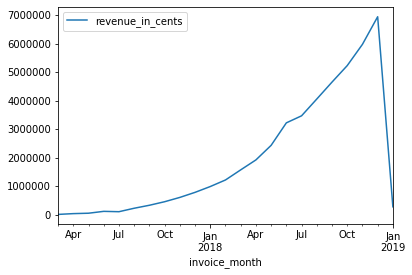

In [6]:
# plot recurring (ie not initial) revenue (ie cost minus credit) over time
# exclude workspaces that paid < $10 (excl credit) when invoice is generated

invoices_df['revenue_in_cents'] = (
    invoices_df['total_cost_in_cents']
    - invoices_df['total_paid_in_credits_in_cents']
)
invoices_df['rev_prev_invoices'] = (
    invoices_df.groupby('workspace_id')['revenue_in_cents'].cumsum() 
    - invoices_df['revenue_in_cents']
)
# TODO: clunky https://stackoverflow.com/a/49869631
invoices_df['invoice_month'] = invoices_df['invoice_time'].dt.to_period('M').dt.to_timestamp() 

(
    invoices_df
    .query("(type != 'initial') & (rev_prev_invoices >= 1000)")
    .groupby('invoice_month')
    .agg({'revenue_in_cents': sum})
    .plot()
)


### Question 2:

Using the first initial invoice month as a cohort, build a cohort analysis table which shows the number of paid seats and number of paying workspaces for each cohort for every subsequent month.


In [7]:
# build a df of number of seats in each workspace each invoice-month
df = collab_df.merge(invoices_df, how='inner', on='workspace_id', suffixes=['_collab','_invoice'])
df.head()

,id_collab,user_id,workspace_id,created_time,deleted_time,collab_created_date,collab_deleted_date,id_invoice,invoice_time,type,total_cost_in_cents,total_paid_in_credits_in_cents,invoice_date,revenue_in_cents,rev_prev_invoices,invoice_month
0,col4026991301698,usr9100864407465,wks1900402835637,2017-01-05 13:41:28,NaT,2017-01-05,NaT,inv2018937041522,2017-03-05,initial,0,0,2017-03-05,0,0,2017-03-01
1,col4026991301698,usr9100864407465,wks1900402835637,2017-01-05 13:41:28,NaT,2017-01-05,NaT,inv4438347086259,2017-04-02,renewal,17914,0,2017-04-02,17914,0,2017-04-01
2,col4026991301698,usr9100864407465,wks1900402835637,2017-01-05 13:41:28,NaT,2017-01-05,NaT,inv962526779505,2017-04-30,renewal,16628,0,2017-04-30,16628,17914,2017-04-01
3,col4026991301698,usr9100864407465,wks1900402835637,2017-01-05 13:41:28,NaT,2017-01-05,NaT,inv726521259136,2017-05-28,renewal,18257,0,2017-05-28,18257,34542,2017-05-01
4,col4026991301698,usr9100864407465,wks1900402835637,2017-01-05 13:41:28,NaT,2017-01-05,NaT,inv3691723277412,2017-06-25,final,21085,0,2017-06-25,21085,52799,2017-06-01


In [8]:
# monthly workspace stats
query = "(invoice_date >= collab_created_date)"
query += " & ( (invoice_date <= collab_deleted_date) | (collab_deleted_date.isnull()) )"

monthly_df = (
    df
    .query(query, engine='python') # https://stackoverflow.com/a/54099389
    .groupby(['workspace_id','invoice_date'])
    .agg(
        {
            'user_id':'count', 
            'revenue_in_cents':'max' # or sum?
        }
    )
    .rename({'user_id':'seats'}, axis='columns')
    .reset_index()
    .merge(workspace_df[['id','owner_id']], left_on='workspace_id', right_on='id')
    .drop('id',axis='columns')
)
monthly_df.head()


,workspace_id,invoice_date,seats,revenue_in_cents,owner_id
0,wks1033126545957,2018-02-22,1,1900,usr7168617444103
1,wks1033126545957,2018-03-22,2,5485,usr7168617444103
2,wks1033126545957,2018-04-19,3,8442,usr7168617444103
3,wks1033126545957,2018-05-17,5,14142,usr7168617444103
4,wks1033126545957,2018-06-14,6,14657,usr7168617444103


           owner_id   cohort
0  usr1010124529784  2018-11
1  usr1020006202032  2018-12
2   usr105277903024  2018-02
3  usr1055301275988  2017-06
4  usr1069411924699  2018-03


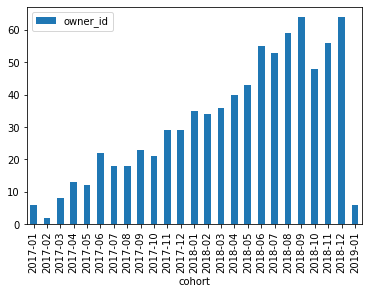

In [9]:
# map each workspace owner to their cohort
owner_cohort_df = (
    invoices_df
    .query('type=="initial"')
    .merge(workspace_df, left_on='workspace_id', right_on='id')
    .groupby('owner_id')
    .agg({'invoice_date':'min'})
    .reset_index()
)

owner_cohort_df['cohort'] = owner_cohort_df['invoice_date'].dt.to_period('M')#.dt.to_timestamp()
owner_cohort_df.drop('invoice_date', axis='columns', inplace=True)

print(owner_cohort_df.head())
# plot size of cohorts of owners (paying or not)
(
    owner_cohort_df
    .groupby('cohort')
    .agg({'owner_id':'count'})
    .plot(kind='bar')
)

In [10]:
final_df = (
    monthly_df
    .merge(owner_cohort_df, on='owner_id')
)
final_df['month'] = final_df['invoice_date'].dt.to_period('M')
final_df.head()

,workspace_id,invoice_date,seats,revenue_in_cents,owner_id,cohort,month
0,wks1033126545957,2018-02-22,1,1900,usr7168617444103,2018-01,2018-02
1,wks1033126545957,2018-03-22,2,5485,usr7168617444103,2018-01,2018-03
2,wks1033126545957,2018-04-19,3,8442,usr7168617444103,2018-01,2018-04
3,wks1033126545957,2018-05-17,5,14142,usr7168617444103,2018-01,2018-05
4,wks1033126545957,2018-06-14,6,14657,usr7168617444103,2018-01,2018-06


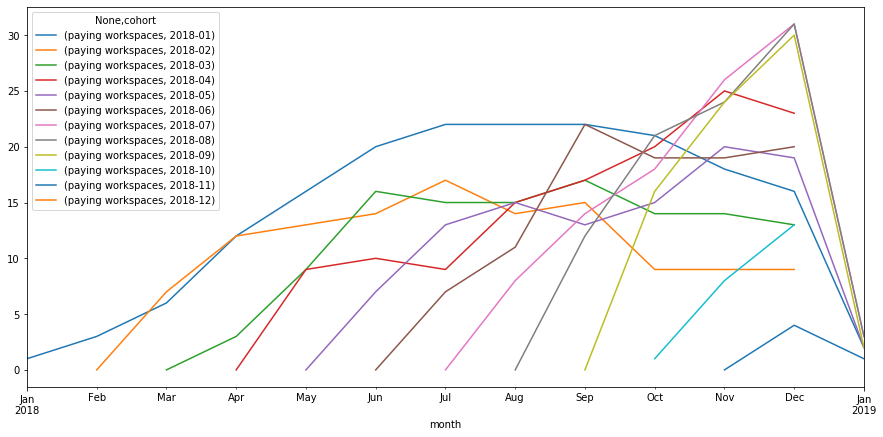

In [11]:
# count *paying* workspaces by owner cohort and over time
# https://stackoverflow.com/a/17266172
plot_df = pd.DataFrame(
    final_df.groupby(['cohort','month']).apply(lambda x: x[x['revenue_in_cents']>0]['workspace_id'].count())
).rename({0:'paying workspaces'},axis='columns')

fig, ax = plt.subplots(figsize=(15,7))
plot_df.query('cohort>="2018-01"').unstack(level=0).plot(ax=ax)

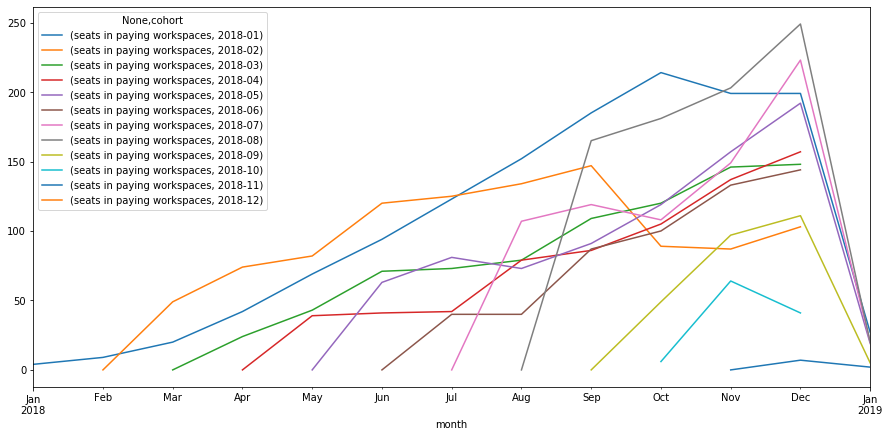

In [12]:
# count all workspaces, paying workspaces, seats of all workspaces, and seats for paying workspaces 
# https://stackoverflow.com/a/17266172
plot_df = pd.DataFrame(
    final_df.groupby(['cohort','month']).apply(lambda x: x[x['revenue_in_cents']>0]['seats'].sum())
).rename({0:'seats in paying workspaces'},axis='columns')

fig, ax = plt.subplots(figsize=(15,7))
plot_df.query('cohort>="2018-01"').unstack(level=0).plot(ax=ax)